In [1]:
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.core.debugger import set_trace
import os
import random
import time
# from faker import Faker
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import DataFrameMapper
from sklearn import pipeline,preprocessing,metrics,model_selection,ensemble
import itertools
import pickle
%matplotlib inline
sns.set()

Using TensorFlow backend.


In [2]:
df = pd.read_csv(r'C:\\Users\\FinTech\\Desktop\\ml_app\\fruadAPp\\PS_20174392719_1491204439457_log.csv')
only_fraud = df[df['isFraud'] == 1] # fishing out non-fraudulent cases
not_fraud = df[df['isFraud'] == 0] # fishing out fraudulent cases
data_notFraud = not_fraud.sample(n = 1000000, random_state = 0) # randomly selecting 1M non-fraudulent cases from the dataset 
fraud_dataframe = pd.concat([only_fraud, data_notFraud], axis=0)  # Joining them together

In [3]:
# fraud_dataframe['oldbalanceDest'].unique()
# fraud_dataframe.info()

In [4]:
# mapper = DataFrameMapper([
#                         (['nameOrig'], preprocessing.OneHotEncoder()),
#                         (['nameDest'], preprocessing.OneHotEncoder()),
#                         (['type'], preprocessing.OneHotEncoder()),
#                         (['step'], preprocessing.MinMaxScaler()),
#                         (['type'], preprocessing.MinMaxScaler()),
#                         (['amount'], preprocessing.MinMaxScaler()),
#                         (['nameOrig'], preprocessing.MinMaxScaler()),
#                         (['oldbalanceOrg'], preprocessing.MinMaxScaler()),
#                         (['newbalanceOrig'], preprocessing.MinMaxScaler()),
#                         (['nameDest'], preprocessing.MinMaxScaler()),
#                         (['oldbalanceDest'], preprocessing.MinMaxScaler()),
#                         (['newbalanceDest'], preprocessing.MinMaxScaler()),
#                         (['step'], preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['type'], preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['amount'],preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['nameOrig'], preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['oldbalanceOrg'], preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['newbalanceOrig'], preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['nameDest'], preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['oldbalanceDest'], preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#                         (['newbalanceDest'], preprocessing.PolynomialFeatures(degree=2, include_bias=False))
#                         ], df_out=True)

In [5]:
# pipeline_obj = pipeline.Pipeline([
#     ('mapper',mapper),
#     ("model", XGBClassifier(objective= 'binary:logistic',nthread=4,seed=0,learning_rate = 0.1,n_estimators=1000))
# ])
# mapper.head()
# X=['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
#        'nameDest', 'oldbalanceDest', 'newbalanceDest']
# Y=['isFraud']
# pipeline_obj.fit(fraud_dataframe[X],fraud_dataframe[Y])

In [6]:
def df_edit(fraud_dataframe):
    label = LabelEncoder()
    fraud_dataframe['nameOrig'] = label.fit_transform(fraud_dataframe['nameOrig']) #encoding the nameorig
    fraud_dataframe['nameDest']= label.fit_transform(fraud_dataframe['nameDest'])
    fraud_dataframe['type']= label.fit_transform(fraud_dataframe['type'])#encoding the namedest
    df1 = pd.get_dummies(fraud_dataframe) # making dummies on the type of transaction
    features = df1.drop(['isFraud','isFlaggedFraud'],axis=1)
    
    #preprocessing the data using scalers
    scaler = MinMaxScaler() # to reduce higher spread of dimentionality and outliers
    scaler.fit(features)
    featuress = scaler.transform(features)
    feat_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(featuress) #adding polynomial features
    return feat_poly 

X = df_edit(fraud_dataframe)
target = fraud_dataframe['isFraud'] # making the isFraud column the target variable. 

# Splitting the dataset.    
X_train,X_test,y_train,y_test = train_test_split(X, target, test_size=0.3, random_state = 0)

In [7]:
X.shape

(1008213, 54)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299983
           1       0.98      0.92      0.95      2481

    accuracy                           1.00    302464
   macro avg       0.99      0.96      0.97    302464
weighted avg       1.00      1.00      1.00    302464

Recall metric in the test dataset: 92.14026602176541%


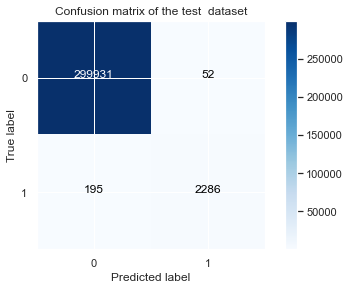

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# dtf_model = DecisionTreeClassifier(max_features='auto', random_state=0, splitter ='best',max_depth = 1000, class_weight={0:1, 1:12},  max_leaf_nodes=150)
# rf_model = RandomForestClassifier(n_estimators=1000,class_weight={0:1, 1:12}, bootstrap = True, max_depth=100)

xbg_model = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=0,
    learning_rate = 0.1,
    n_estimators=1000
)

xbg_model.fit(X_train, y_train)
predictions = xbg_model.predict(X_test)
print(metrics.classification_report(y_test, predictions))

#plotting confusion matrix. 
cnf_matrix_tra = confusion_matrix(y_test, predictions)
print("Recall metric in the test dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix of the test  dataset') 
plt.show()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    799618
           1       0.18      0.53      0.27       382

    accuracy                           1.00    800000
   macro avg       0.59      0.76      0.64    800000
weighted avg       1.00      1.00      1.00    800000

Recall metric in the validation dataset: 52.617801047120416%


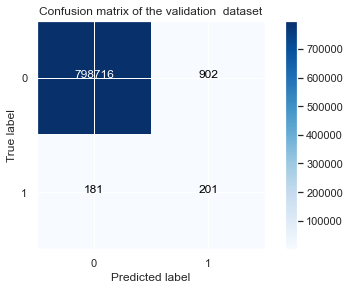

In [9]:
 df_ver = df[100000:900000] 
df_ver_classes = pd.value_counts(df_ver['isFraud'], sort=True)
#df_ver_classes
target_vali = df_ver['isFraud']

features_vali = df_edit(df_ver)

predict_valid = xbg_model.predict(features_vali)
print(metrics.classification_report(target_vali, predict_valid))

#plotting confusion matrix. 
cnf_matrix_tra = confusion_matrix(target_vali, predict_valid)
print("Recall metric in the validation dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix of the validation  dataset') 
plt.show()

In [10]:
# import sklearn.external.joblib as extjoblib
import joblib
joblib.dump(xbg_model,'RFModelforfraud_2.pkl')

['RFModelforfraud_2.pkl']

In [11]:
modelReload=joblib.load('RFModelforfraud_2.pkl')

modelReload.predict(features_vali)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [12]:
temp={}
temp['step']=100
temp['type']= 'TRANSFER'
temp['amount']=47664
temp['nameOrig']= 'C1720120297'
temp['oldbalanceOrg']=500000
temp['newbalanceOrig']=100664
temp['nameDest']= 'C496863720'
temp['oldbalanceDest']=1605021.18
temp['newbalanceDest']=1000000.89

In [13]:
testDtaa=pd.DataFrame({'x':temp}).transpose()
testDtaa 

,amount,nameDest,nameOrig,newbalanceDest,newbalanceOrig,oldbalanceDest,oldbalanceOrg,step,type
x,47664,C496863720,C1720120297,1e+06,100664,1.60502e+06,500000,100,TRANSFER


In [14]:
def df_edit_2(fraud_dataframe):
    label = LabelEncoder()
    fraud_dataframe['nameOrig'] = label.fit_transform(fraud_dataframe['nameOrig']) #encoding the nameorig
    fraud_dataframe['nameDest']= label.fit_transform(fraud_dataframe['nameDest'])
    fraud_dataframe['type']= label.fit_transform(fraud_dataframe['type'])#encoding the namedest
    df1 = pd.get_dummies(fraud_dataframe) # making dummies on the type of transaction
#     features = df1.drop(['isFraud','isFlaggedFraud'],axis=1)
    
    #preprocessing the data using scalers
    scaler = MinMaxScaler() # to reduce higher spread of dimentionality and outliers
    scaler.fit(df1)
    featuress = scaler.transform(df1)
    feat_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(featuress) #adding polynomial features
    return feat_poly 



fraud = df_edit_2(testDtaa)

In [15]:
fraud.shape

(1, 54)

In [16]:
modelReload.predict(fraud)[0]

1